## imports


In [34]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import mlflow
import torch
import bentoml
import onnx

## hyperparameter


In [ ]:
data_path = "../data/cifar10"
train_path = f"{data_path}/train"
test_path = f"{data_path}/test"
model_path = f"../models/cifar10"
batch_size = 64
size = (32, 32)
valid_split = 0.2
num_class = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment("cifar-classificaion")

## data load


In [ ]:
transform = transforms.Compose([
	transforms.ToTensor()
])

full_train_ds = ImageFolder(root=train_path, transform=transform)
valid_size = int(valid_split * len(full_train_ds))
train_ds, valid_ds = random_split(full_train_ds, [len(full_train_ds) - valid_size, valid_size])

train_ds.dataset = ImageFolder(root=train_path, transform=transform)
valid_ds.dataset = ImageFolder(root=train_path, transform=transform)

train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_ld = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

test_ds = ImageFolder(root=test_path, transform=transform)
test_ld = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

num_class = len(full_train_ds.classes)

In [16]:
next(iter(train_ld))[0].numpy()

array([[[[0.57254905, 0.42352942, 0.5686275 , ..., 0.42745098,
          0.4509804 , 0.3372549 ],
         [0.6117647 , 0.5411765 , 0.6431373 , ..., 0.38431373,
          0.42352942, 0.34509805],
         [0.56078434, 0.5647059 , 0.5921569 , ..., 0.3372549 ,
          0.4627451 , 0.34901962],
         ...,
         [0.7019608 , 0.7019608 , 0.7254902 , ..., 0.1764706 ,
          0.16862746, 0.18431373],
         [0.7058824 , 0.7058824 , 0.73333335, ..., 0.18431373,
          0.18039216, 0.19607843],
         [0.70980394, 0.7058824 , 0.7294118 , ..., 0.17254902,
          0.17254902, 0.18039216]],

        [[0.5803922 , 0.44313726, 0.64705884, ..., 0.44705883,
          0.48235294, 0.35686275],
         [0.62352943, 0.57254905, 0.7411765 , ..., 0.40392157,
          0.44313726, 0.3647059 ],
         [0.58431375, 0.5803922 , 0.60784316, ..., 0.34509805,
          0.46666667, 0.36862746],
         ...,
         [0.69411767, 0.6862745 , 0.7058824 , ..., 0.17254902,
          0.16470589, 0.1

### visualization


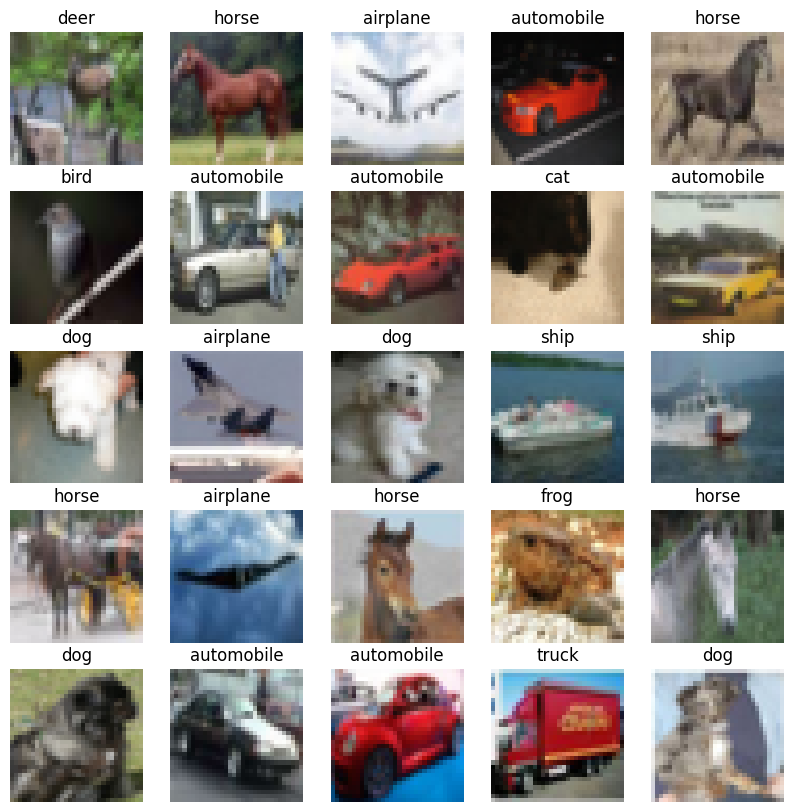

In [5]:
images, labels = next(iter(train_ld))
classes = full_train_ds.classes

plt.figure(figsize=(10, 10))
for i in range(25):
	img = images[i].permute(1, 2, 0)
	plt.subplot(5, 5, i + 1)
	plt.imshow(img.numpy())
	plt.title(f"{classes[labels[i].item()]}")
	plt.axis("off")
plt.show()

## Model


In [40]:
class CifarClassifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.flat = nn.Flatten()
		self.fc1 = nn.Linear(64 * 8 * 8, 128)
		self.fc2 = nn.Linear(128, 10)
		
	def forward(self, x):
		x = nn.ReLU()(self.conv(x))
		x = self.pool(x)
		x = nn.ReLU()(self.conv2(x))
		x = self.pool(x)
		x = self.flat(x)
		x = nn.ReLU()(self.fc1(x))
		x = self.fc2(x)
		return x

	def __getstate__(self):
		return super().__getstate__()

	def __setstate__(self, state):
		return super().__setstate__(state)
	
model = CifarClassifier()

## train


In [41]:
with mlflow.start_run():
	lr_rate = 0.001
	loss_fn = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr_rate)
	num_epochs = 5
	mlflow.log_param("learning_rate", lr_rate)
	mlflow.log_param("batch_size", batch_size)
	mlflow.log_param("epochs", num_epochs)

	model.to(device)

	for epoch in range(num_epochs):
		model.train()
		total_loss = 0
		correct_train = 0
		total_train = 0
		for images, labels in train_ld:
			images = images.to(device)
			labels = labels.to(device)
		
			optimizer.zero_grad()
			outputs = model(images)
			loss = loss_fn(outputs, labels)
			loss.backward()
			optimizer.step()
		
			total_loss += loss.item()
			_,  predicted = torch.max(outputs, 1)
			correct_train += (predicted == labels).sum().item()
			total_train += labels.size(0)
	
		model.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for images, labels in valid_ld:
				images = images.to(device)
				labels = labels.to(device)
			
				outputs = model(images)
				_, predicted = torch.max(outputs, 1)
				correct += (predicted == labels).sum().item()
				total += labels.size(0)
	
		avg_loss = total_loss / len(train_ld)
		accuracy = correct_train / total_train
		valid_accuracy = correct / total
		mlflow.log_metric("loss", loss.item(), step=epoch)
		mlflow.log_metric("avg_loss", avg_loss, step=epoch)
		mlflow.log_metric("accuracy", accuracy, step=epoch)
		mlflow.log_metric("val_accuracy", valid_accuracy, step=epoch)
		print(f"epoch: {epoch + 1}/{num_epochs} - loss: {avg_loss:.3f} - accuracy: {accuracy:.3f} - valid accuracy: {valid_accuracy:.3f}")

	model.to("cpu")
	mlflow.pytorch.log_model(model, name="model", input_example=torch.randn(1, 3, 32, 32).numpy())
	

epoch: 1/5 - loss: 1.527 - accuracy: 0.448 - valid accuracy: 0.547
epoch: 2/5 - loss: 1.185 - accuracy: 0.581 - valid accuracy: 0.606
epoch: 3/5 - loss: 1.036 - accuracy: 0.637 - valid accuracy: 0.641
epoch: 4/5 - loss: 0.935 - accuracy: 0.674 - valid accuracy: 0.649
epoch: 5/5 - loss: 0.850 - accuracy: 0.702 - valid accuracy: 0.672


## save model


In [25]:
torch.save(model.state_dict(), f"{model_path}/model.pt")

In [ ]:
# Example input
dummy_input = torch.randn(1, 3, 32, 32)

# Convert to TorchScript
traced_model = torch.jit.trace(model, dummy_input)
torch.jit.save(traced_model, f"{model_path}/model_torchscript.pt")

print("TorchScript model saved!")

torch.onnx.export(
    model,
    dummy_input,
    f"{model_path}/model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print("ONNX model saved!")

TorchScript model saved!
ONNX model saved!


### bentoml


In [42]:
torch.save(model, "./torch.pt")


In [44]:
# model = torch.jit.load(f"{model_path}/model_torchscript.pt")
model = torch.load("./torch.pt", weights_only=False)
bento_model = bentoml.pytorch.save_model(
    "cifar10_torchscript",
    model,
    signatures={"__call__": {"batchable": True}}
)

print("Saved to BentoML store:", bento_model)

onnx_model = onnx.load(f"{model_path}/model.onnx")
onnx_model = bentoml.onnx.save_model(
    "cifar10_onnx",
    model=onnx_model
)

print("Saved to BentoML store:", onnx_model)

Saved to BentoML store: Model(tag="cifar10_torchscript:yo7bqod2z6imf3bo")
Saved to BentoML store: Model(tag="cifar10_onnx:ypab3vt2z6imf3bo")


In [55]:
import requests
import numpy as np

# dummy input
x = np.random.rand(1, 3, 32, 32).astype(np.float32)

# convert to list before sending
data = {"input": x.tolist()}  # wrap in a dict

resp = requests.post("http://localhost:3000/predict", json=data)
print(resp.json())

{'error': 'An unexpected error has occurred, please check the server log.'}
